---
title: Smart Constructors and ayclic egraphs
---


https://www.philipzucker.com/bottom_up/
I mentioned that it reminded me of aegraphs.
Jamie responded on mastodon


Hashconsing.
You don't want to hash recursively anymore. So we need to override


Top down matching puts each pattern into its head smart constructor
A bottom up style puts each piece into a different smart constructor. Which is a bummer.



https://www.pypy.org/posts/2022/10/toy-optimizer-allocation-removal.html
JIT is straight line which is pretty cool.

JIT guards are like asserts. They have a notion of context that we learn things that are true past them

cleaning up allocations is important. Analsysi to avoid calling new or onlycall new after its settled down
Assume type data objects haven't changed.

https://github.com/tekknolagi/zero-to-aegraphs/tree/trunk

https://www.pypy.org/posts/2022/07/toy-optimizer.html

Version Space Algebras

In [2]:
# multiterms



def add(x,y):
    return [("add", x,y)]

def div(x,y):
    return [("div", x,y)]

def mul(x,y):
    return [("mul", x,y)]

def lit(x):
    return [("lit", x)]

def lshift(x,y):
    return [("lshift", x,y)]

# obviously the pattern can be abstracted as
def multiterm(sym):
    def res(*args):
        return [(sym, *args)]
    return res



In [ ]:
def mul(x,y):
    res = [("mul", x,y)]
    if lit(1) in x:
        res.append(y)
    if lit(1) in y:
        res.append(x)
    if lit(2) in y:
        res.extend(lshift(x,lit(1)))
    return res

def div(x,y):
    pass

In [ ]:
# aegraph






In [1]:
import dataclasses
from typing import Optional, Tuple


class Value:
    def find(self):
        raise NotImplementedError("abstract")

    def _set_forwarded(self, value):
        raise NotImplementedError("abstract")


@dataclasses.dataclass(eq=True, unsafe_hash=True)
class Constant(Value):
    value: object

    def find(self):
        return self

    def _set_forwarded(self, value: Value):
        assert isinstance(value, Constant) and value.value == self.value


@dataclasses.dataclass(eq=True, unsafe_hash=True)
class Operation(Value):
    name: str
    args: tuple[Value]
    forwarded: Optional[Value] = dataclasses.field(default=None, hash=False)

    __match_args__ = ("name", "args")

    def find(self) -> Value:
        op = self
        while isinstance(op, Operation):
            next = op.forwarded
            if next is None:
                return op
            op = next
        return op

    def arg(self, index):
        return self.args[index].find()

    def make_equal_to(self, value: Value):
        self.find()._set_forwarded(value)

    def _set_forwarded(self, value: Value):
        self.forwarded = value


@dataclasses.dataclass
class EGraph(list):
    seen: dict[Tuple[str, Tuple[Value, ...]], Value] = dataclasses.field(
        default_factory=dict
    )

    def _emit(self, op):
        key = (op.name, op.args)
        if key in self.seen:
            return self.seen[key]
        self.seen[key] = op
        self.append(op)
        return op

    def add(self, left, right):
        match (left, right):
            case (Constant(a), Constant(0)):
                return left
            case _:
                return self._emit(Operation("add", (left, right)))

    def mul(self, left, right):
        match (left, right):
            # case (_, Constant(2)):
            #     return Operation("lshift", [left, Constant(1)])
            case _:
                return self._emit(Operation("mul", (left, right)))

    def div(self, left, right):
        match (left, right):
            # case (_, Constant(2)):
            #     return Operation("rshift", [left, Constant(1)])
            case (Operation("mul", (a, b0)), b1) if b0 == b1:
                return a
            case _:
                return self._emit(Operation("div", (left, right)))


def bb_to_str(bb: EGraph, varprefix: str = "var"):
    def arg_to_str(arg: Value):
        if isinstance(arg, Constant):
            return str(arg.value)
        else:
            return varnames[arg]

    varnames = {}
    res = []
    for index, op in enumerate(bb):
        if isinstance(op, Constant):
            continue
        var = f"{varprefix}{index}"
        varnames[op] = var
        arguments = ", ".join(arg_to_str(op.arg(i)) for i in range(len(op.args)))
        strop = f"{var} = {op.name}({arguments})"
        res.append(strop)
    return "\n".join(res)


a = Constant(42)
bb = EGraph()
b = bb.mul(a, Constant(2))
bb.mul(a, Constant(2))
bb.mul(a, Constant(2))
bb.mul(a, Constant(2))
bb.mul(a, Constant(2))
bb.mul(a, Constant(2))
bb.mul(a, Constant(2))
c = bb.div(b, Constant(2))
print(bb_to_str(bb))
print(c)

var0 = mul(42, 2)
Constant(value=42)


In [26]:
table = {}
def hashcons(c):
    c1 = table.get(c)
    if c1 == None:
        table[c] = c 
        return c
    else:
        return c1
# simple hash consing. Not type safe. Has non short circuiting equality.
# still maybe it's good enough


a = hashcons((1,2,3))
b = hashcons((1,2,3))
c = (1,2,3)
assert not c is b
assert a is b

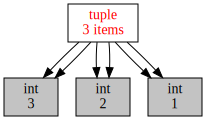

In [30]:
import objgraph
objgraph.show_refs((a,b))

In [38]:
table = {} # hashable -> Intern(hashable)
def hashcons(c):
    c1 = table.get(c)
    if c1 == None:
        c1 = Intern(c)
        table[c] = c1 
        return c1
    else:
        return c1
    
from dataclasses import dataclass
@dataclass(frozen=True, slots=True)
class Intern():
    data: "Any"
    def __hash__(self):
        print("hashing", self)
        return hash(id(self))
    def __eq__(self, other):
        print("==?", self, other)
        return self is other

a = hashcons((1,2,3))
b = hashcons((1,2,3))
a == b
table

x = hashcons(())
print("y")
y = hashcons((x,x))
print("z")
z = hashcons((y,))
z1 = hashcons((y,))
assert z1 is z
w = hashcons((z,z,z))

==? Intern(data=(1, 2, 3)) None
==? Intern(data=(1, 2, 3)) Intern(data=(1, 2, 3))
y
hashing Intern(data=())
hashing Intern(data=())
hashing Intern(data=())
hashing Intern(data=())
z
hashing Intern(data=(Intern(data=()), Intern(data=())))
hashing Intern(data=(Intern(data=()), Intern(data=())))
hashing Intern(data=(Intern(data=()), Intern(data=())))
==? Intern(data=(Intern(data=(Intern(data=()), Intern(data=()))),)) None
hashing Intern(data=(Intern(data=(Intern(data=()), Intern(data=()))),))
hashing Intern(data=(Intern(data=(Intern(data=()), Intern(data=()))),))
hashing Intern(data=(Intern(data=(Intern(data=()), Intern(data=()))),))
hashing Intern(data=(Intern(data=(Intern(data=()), Intern(data=()))),))
hashing Intern(data=(Intern(data=(Intern(data=()), Intern(data=()))),))
hashing Intern(data=(Intern(data=(Intern(data=()), Intern(data=()))),))


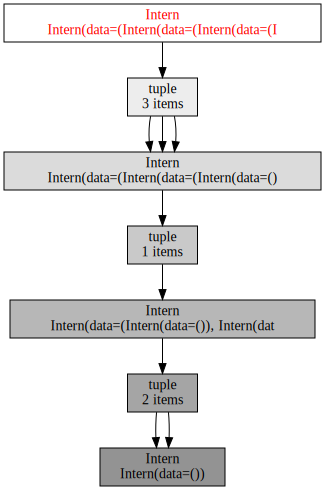

In [39]:
# https://mg.pov.lt/objgraph/ visualizer of object graph
import objgraph
objgraph.show_refs([w], max_depth=10, filter = lambda x: not isinstance(x,type))

Smart constructors

I can have add auto recognize 0, const prop, and associativity commutativity.

We're pretty used to the behavior in the context of representing polynomials. Sympy is rotten with this kind of thing, which can be a problem for some use cases.

This is showing just basic 

In [ ]:
# ok so consider if smart cosnturctor outputs a set/list of interned nodes instead of 

def mul(x,y):
    out = [("mul", x, y)]
    if y == 2:
        out.append(("<<", x, 1))
    return out

# Can I do ematcjing with respect to a previous 

# now matching through finds the indirections
def div(x,y):
    out = [("div", x, y)]
    for x in xs:
        match x:
            case ("mul", a, n):
                for y in ys:
                    match y:
                        case n:
                            out.append(x)
# oh yea. I forgot when you top down ematch it's pretty simple too for concrete problems.


# so where does the union find come in?
# Well, we may discover new versions coming from above.
# Seems marginal though.

# But if I don't, we don't learn anything?




In [5]:
def add(x,y):
    if x == 0:
        return y
    elif y == 0:
        return x
    elif isinstance(x,int) and isinstance(y,int): # const prop
        return x + y
    match y:
        case ("add", ybits):
            ys = ybits
        case _:
            ys = [y]
    match x:
        case ("add", xbits):
            xs = xbits
        case _:
            xs = [x]
    return ("add",sorted(xs + ys))   # hashcons 

add(1,add(2,"x"))



TypeError: '<' not supported between instances of 'str' and 'int'

In [ ]:



options = {}
partials = {}

def hashcons(con):
    match con:
        case ("add", a, b):
            if a == 0:
                return b
            else 
        case ("mul", a, b):
    
    return options, partials













cascades

aegraph
tree of unions

But later things can tap into the frozenset. hmm.
so maybe nested frozensets

smart construcotrs - hashcons frozenset

25-30 minutes. yowzers

Use z3 external egraph. Bottom up, aegraph or grs style.


```python

def add(x,y):
    match x:
        Add()


```